# DDoS Attacks Detection and Characterization


In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import datetime 
import ipaddress

In [2]:
df = pd.read_csv('ddos_dataset.csv',low_memory=False)

# we create a copy of the original dataset
df_copy = df.copy()
df

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64235,65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64236,65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64237,65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


# Section 1 – Data exploration and pre-processing

## 1. Investigate the provided DDoS attack dataset

I dati sono stati raccolti il giorno 1 dicembre 2018 dalle 09:17:11 alle 13:34:27. TODO: Da tradurre

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    64239 non-null  int64  
 1   Flow ID                       64239 non-null  object 
 2    Source IP                    64239 non-null  object 
 3    Source Port                  64239 non-null  int64  
 4    Destination IP               64239 non-null  object 
 5    Destination Port             64239 non-null  int64  
 6    Protocol                     64239 non-null  int64  
 7    Timestamp                    64239 non-null  object 
 8    Flow Duration                64239 non-null  int64  
 9    Total Fwd Packets            64239 non-null  int64  
 10   Total Backward Packets       64239 non-null  int64  
 11  Total Length of Fwd Packets   64239 non-null  float64
 12   Total Length of Bwd Packets  64239 non-null  float64
 13   

In [4]:
# we fix column names
df.columns = [col.strip().replace(" ", "") for col in df.columns] 

# we drop the first column which is unnecessary
df.drop(columns=['Unnamed:0'],inplace=True)

# we put 1 when the value of SimilarHTTP is different from zero
df['SimillarHTTP'] = df['SimillarHTTP'].apply(lambda x : 1 if x != 0 else 0)
print(df['SimillarHTTP'].value_counts())
df.head()

SimillarHTTP
1    64239
Name: count, dtype: int64


,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,ddos_dns


We now remove columns that have the same value in every row.

In [5]:
unique_val = df.apply(lambda col: col.unique())

col_unique_val = unique_val[unique_val.apply(len) == 1].index

print("Columns meaningless beacuse they have the same value on all rows:")
print(col_unique_val)

df.drop(columns=col_unique_val,inplace=True)

print(f"The dataset has now {df.shape[0]} rows and {df.shape[1]}")

Columns meaningless beacuse they have the same value on all rows:
Index(['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FINFlagCount',
       'PSHFlagCount', 'ECEFlagCount', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SimillarHTTP'],
      dtype='object')
The dataset has now 64239 rows and 74


In [6]:
df.describe()

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Inbound
count,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,...,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,64239.000000
mean,25267.368608,30715.252884,14.362864,5.150614e+06,18.814848,1.304036,6699.521630,2.153348e+03,613.992948,588.863043,...,-4.167229e+07,9.026629e+03,4.878774e+03,1.687791e+04,6.204895e+03,1.155553e+06,2.613584e+05,1.555321e+06,8.908522e+05,0.919566
std,24710.413442,20347.990914,4.706001,2.249713e+07,462.305336,25.199720,20510.320389,9.087201e+04,585.691655,584.276284,...,2.062767e+08,2.045563e+05,1.424082e+05,3.828583e+05,1.667756e+05,5.341380e+06,1.574889e+06,6.993415e+06,4.571276e+06,0.271966
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,-1.062719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,779.000000,12435.500000,17.000000,1.000000e+00,2.000000,0.000000,123.000000,0.000000e+00,53.000000,36.000000,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,29661.000000,30797.000000,17.000000,2.000000e+00,2.000000,0.000000,1050.000000,0.000000e+00,393.000000,375.000000,...,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,48510.500000,49041.500000,17.000000,2.087700e+04,2.000000,0.000000,2944.000000,0.000000e+00,1464.000000,1464.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,65518.000000,65535.000000,17.000000,1.200000e+08,85894.000000,1862.000000,176000.000000,8.829488e+06,3564.000000,2020.000000,...,1.480000e+03,1.678654e+07,2.853681e+07,6.783473e+07,8.349846e+06,1.147455e+08,5.275036e+07,1.147455e+08,1.147455e+08,1.000000


In [7]:
df['FlowID']=df["SourceIP"] + "-" + df["DestinationIP"] + "-" + \
               df["SourcePort"].astype(str) + "-" + \
               df["DestinationPort"].astype(str) + "-" + \
               df["Protocol"].astype(str)
df

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns
1,192.168.50.1-172.16.0.5-634-60495-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag
64235,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag
64236,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag
64237,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,ddos_udp_lag


### BASIC TRAFFIC STATISTICS

In [8]:
n_flow=df['FlowID'].nunique() # 64239
n_src_ip = df["SourceIP"].nunique()
n_dst_ip = df["DestinationIP"].nunique()

print(f"Number of unique source IPs: {n_src_ip}")
print(f"Number of unique destination IPs: {n_dst_ip}")
n_flow

Number of unique source IPs: 216
Number of unique destination IPs: 245


62154

### LABEL DISTRIBUTION

In [9]:
df_masked=df[df['label']=='benign']
num_benign=df_masked['label'].count() # 5658

num_attack=len(df)-num_benign # 58581
num_attackpertype=df[df['label']!='benign'].groupby(["label"]).size()   # int(num_attacktype[i])
num_attackpertype

label
ddos_dns        5369
ddos_ldap       5928
ddos_mssql      5911
ddos_netbios    5830
ddos_ntp         986
ddos_snmp       5984
ddos_ssdp       5970
ddos_syn        5480
ddos_tftp       5261
ddos_udp        5876
ddos_udp_lag    5986
dtype: int64

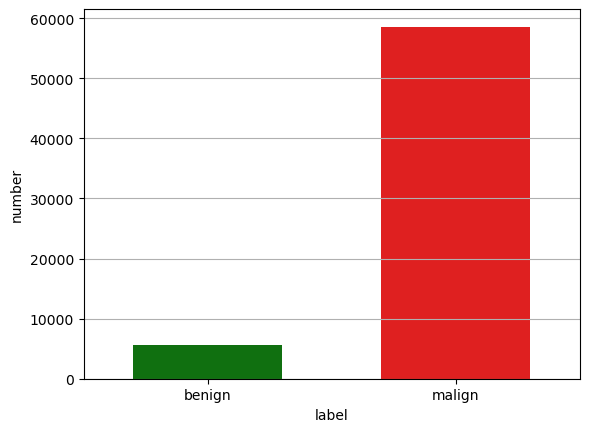

In [10]:
df_benign= pd.DataFrame({
    'label' : ['benign','malign'], 
    'number' : [num_benign, num_attack]
})

sns.barplot(
    data = df_benign, # which dataframe you want to use as the source data
    x = 'label', # which column to use for x-axis
    y = 'number', # which column to use for y-axis
    width=0.6,
    palette = ['green', 'red'],
    hue = 'label',
    legend = False
)
plt.grid(True)             
plt.grid(axis='x')
plt.show()

### TRAFIC LEVEL DISTRIBUITION

#### PROTOCOL

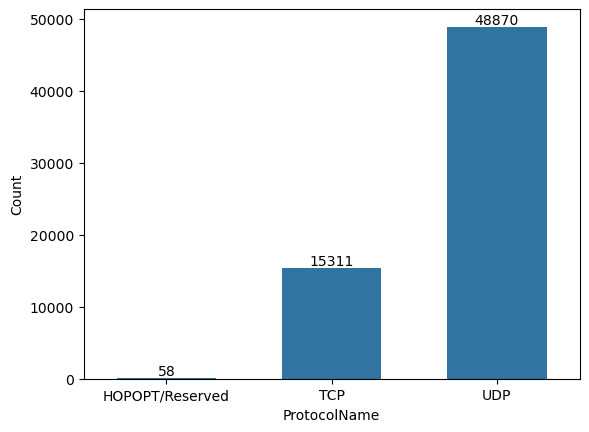

In [11]:
prt_map = {
    6: 'TCP',
    17: 'UDP',
    0: 'HOPOPT/Reserved'
}


df['ProtocolName'] = df['Protocol'].replace(prt_map)

df_prot=df.groupby('ProtocolName')['ProtocolName'].count()
df_prot=pd.DataFrame(df_prot)
df_prot.columns=['Count']

ax = sns.barplot(data = df_prot, x = df_prot.index, y = 'Count', width=0.6)

# Aggiungere i valori sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

### IP SOURCE/DESTINATION 

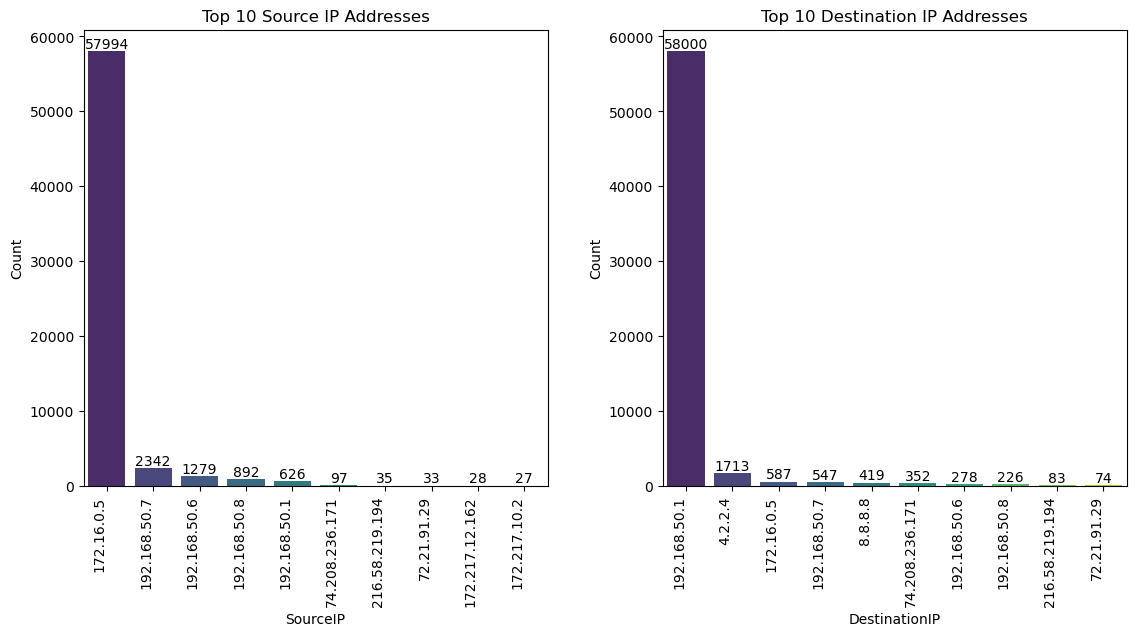

In [12]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist = df['SourceIP'].value_counts().head(10)
IP_Source_dist = pd.DataFrame(IP_Source_dist)
IP_Source_dist.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
    
)
plt.title('Top 10 Source IP Addresses')
plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Destination_dist = df['DestinationIP'].value_counts().head(10)
IP_Destination_dist = pd.DataFrame(IP_Destination_dist)
IP_Destination_dist.columns = ['Count']
ax = sns.barplot(
    data = IP_Destination_dist,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Destination IP Addresses')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

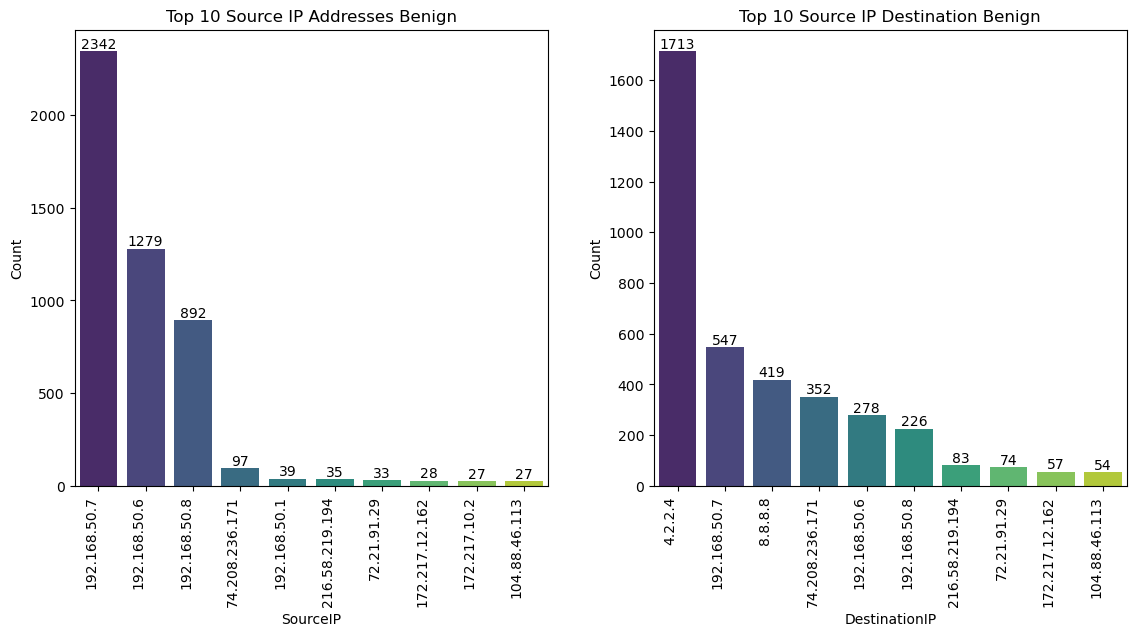

In [13]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist_Benign = df['SourceIP'][df['label'] == 'benign'].value_counts().head(10)
IP_Source_dist_Benign = pd.DataFrame(IP_Source_dist_Benign)
IP_Source_dist_Benign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Benign,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Addresses Benign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Source_dist_Benign = df['DestinationIP'][df['label'] == 'benign'].value_counts().head(10)
IP_Source_dist_Benign = pd.DataFrame(IP_Source_dist_Benign)
IP_Source_dist_Benign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Benign,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Destination Benign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

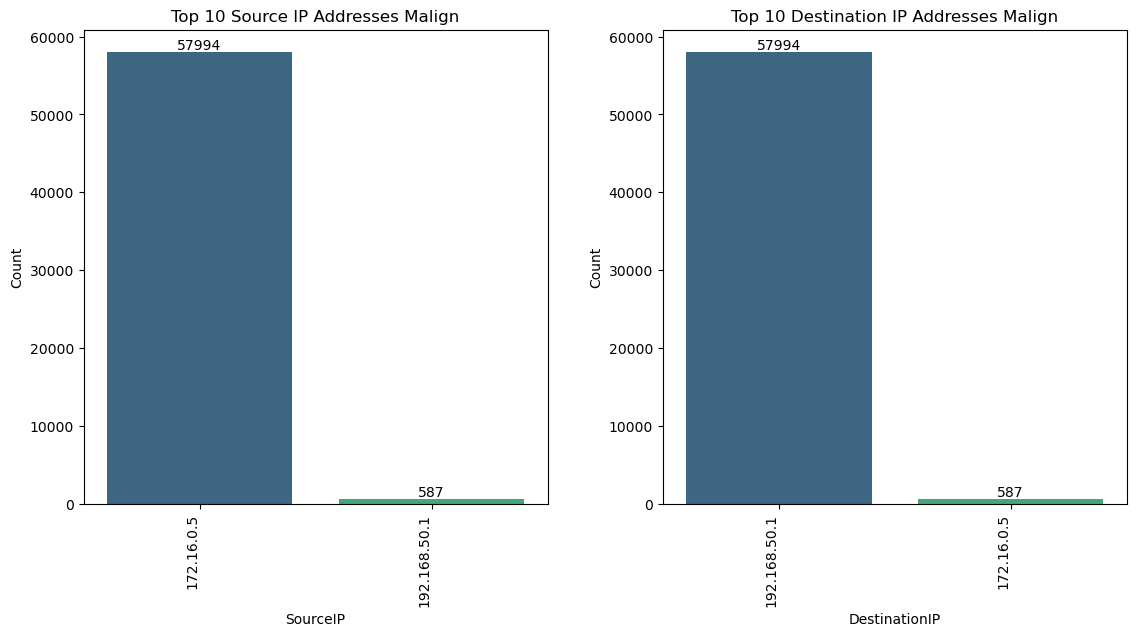

In [14]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
IP_Source_dist_Malign = df['SourceIP'][df['label'] != 'benign'].value_counts().head(10)
IP_Source_dist_Malign = pd.DataFrame(IP_Source_dist_Malign)
IP_Source_dist_Malign.columns = ['Count']
ax = sns.barplot(
    data = IP_Source_dist_Malign,
    x = 'SourceIP',
    y = 'Count',
    palette='viridis',
    hue = 'SourceIP',
    legend = False
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source IP Addresses Malign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.subplot(1,2,2)
IP_Destination_dist_Malign = df['DestinationIP'][df['label'] != 'benign'].value_counts().head(10)
IP_Destination_dist_Malign = pd.DataFrame(IP_Destination_dist_Malign)
IP_Destination_dist_Malign.columns = ['Count']
ax = sns.barplot(
    data = IP_Destination_dist_Malign,
    x = 'DestinationIP',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationIP',
    legend = False
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Destination IP Addresses Malign')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')




plt.tight_layout(pad=3)

### TOP 10 DESTINATION/SOURCE PORTS 

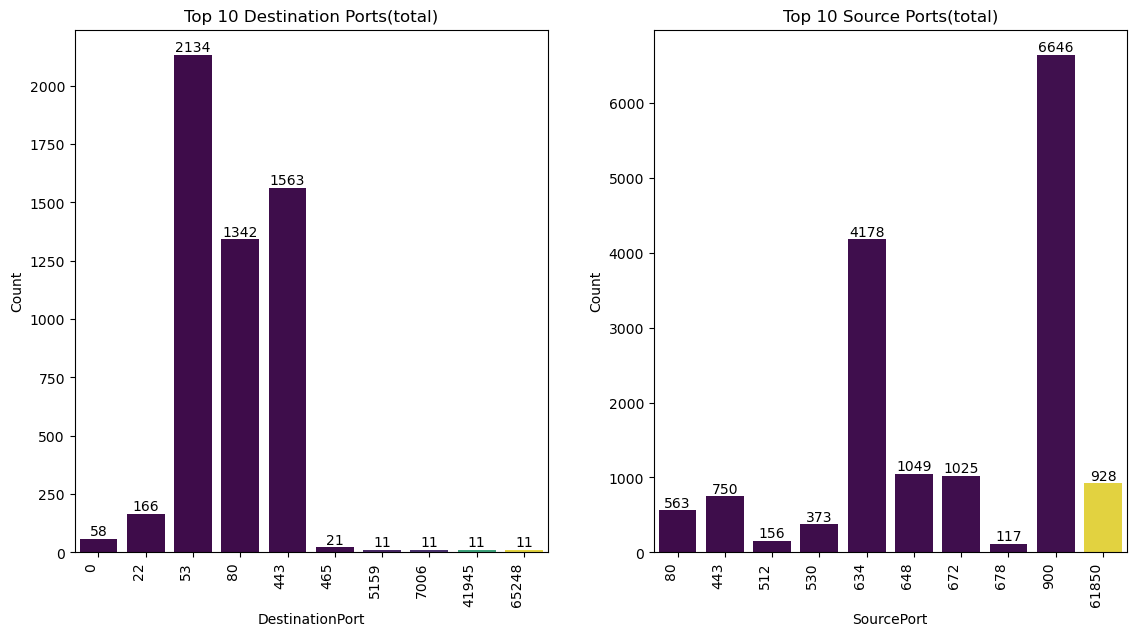

In [15]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
Destination_Port_dist = df['DestinationPort'].value_counts().head(10)
Destination_Port_dist = pd.DataFrame(Destination_Port_dist)
Destination_Port_dist.columns = ['Count']
ax = sns.barplot(
    data = Destination_Port_dist,
    x = 'DestinationPort',
    y = 'Count',
    palette='viridis',
    hue = 'DestinationPort',
    legend = False
    
)
plt.title('Top 10 Destination Ports(total)')
plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')


# secondo subplot, quello a destra
plt.subplot(1,2,2)
Source_Port_dist= df['SourcePort'].value_counts().head(10)
Source_Port_dist = pd.DataFrame(Source_Port_dist)
Source_Port_dist.columns = ['Count']
ax = sns.barplot(
    data = Source_Port_dist,
    x = 'SourcePort',
    y = 'Count',
    palette='viridis',
    hue = 'SourcePort',
    legend = False
    
)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source Ports(total)')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

### TOP 10 DESTINATION / SOURCE PORTS (BENIGN)

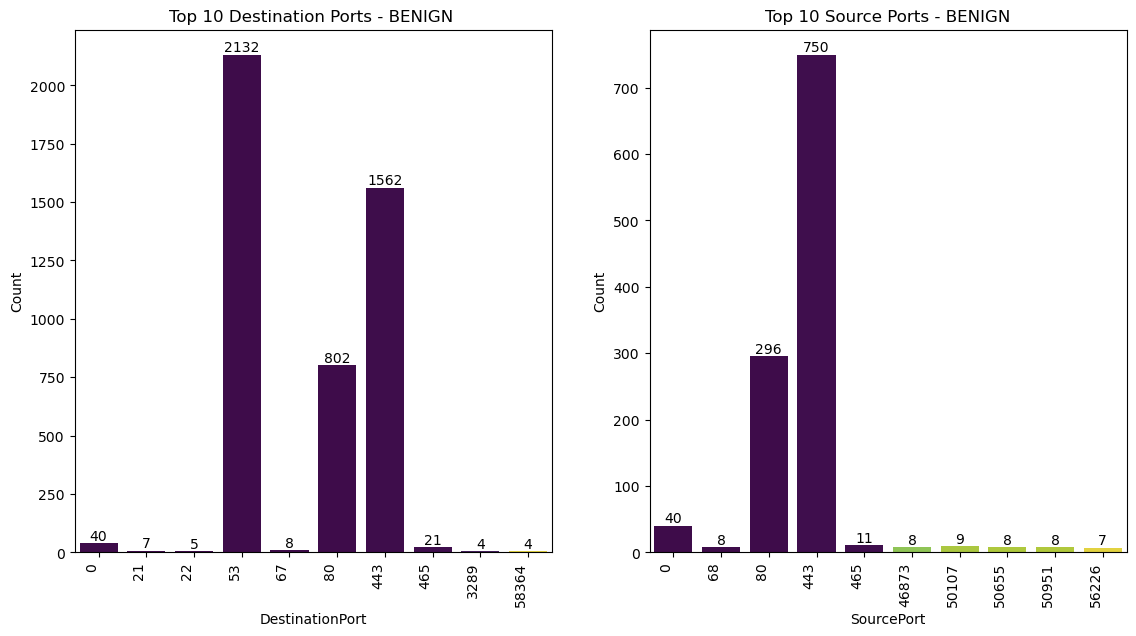

In [16]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
Destination_Port_dist_Benign = df['DestinationPort'][df['label'] == 'benign'].value_counts().head(10)
Destination_Port_dist_Benign = pd.DataFrame(Destination_Port_dist_Benign)
Destination_Port_dist_Benign.columns = ['Count']
ax = sns.barplot(
data = Destination_Port_dist_Benign,
x = 'DestinationPort',
y = 'Count',
palette='viridis',
hue = 'DestinationPort',
legend = False

)
plt.title('Top 10 Destination Ports - BENIGN ')
plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# secondo subplot, quello a destra

plt.subplot(1,2,2)
Source_Port_dist_Benign= df['SourcePort'][df['label'] == 'benign'].value_counts().head(10)
Source_Port_dist_Benign = pd.DataFrame(Source_Port_dist_Benign)
Source_Port_dist_Benign.columns = ['Count']
ax = sns.barplot(
data = Source_Port_dist_Benign,
x = 'SourcePort',
y = 'Count',
palette='viridis',
hue = 'SourcePort',
legend = False

)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source Ports - BENIGN')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

### TOP 10 DESTINATION / SOURCE PORTS (MALIGN)

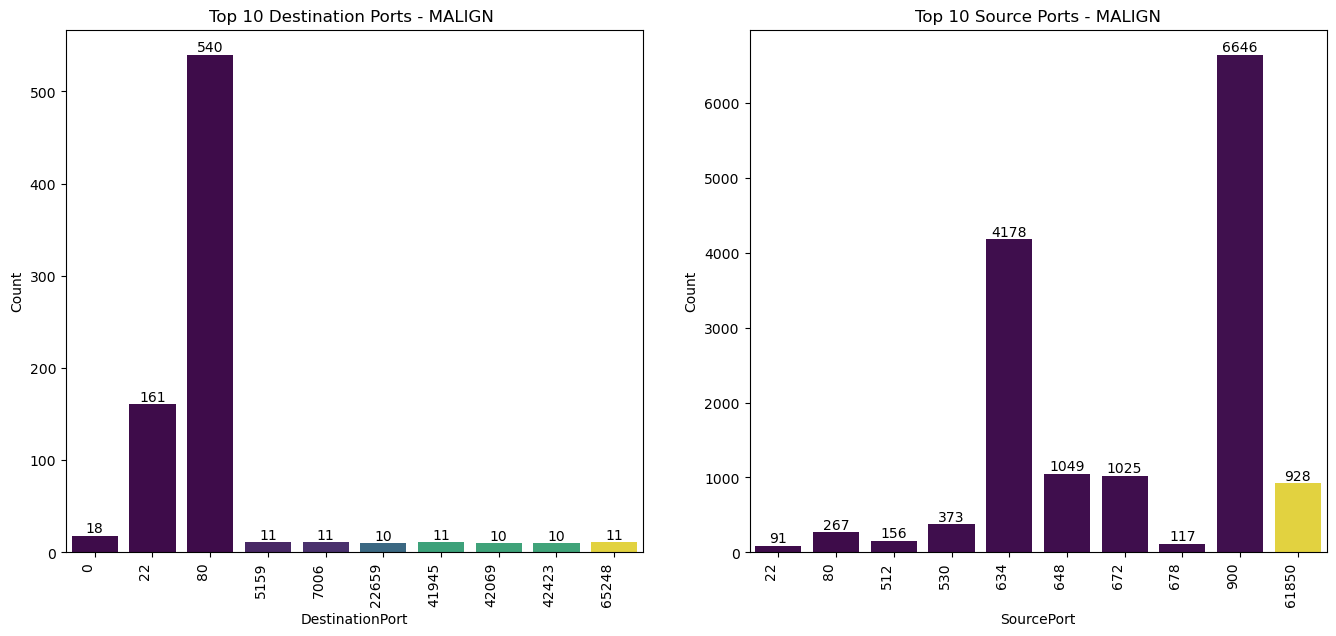

In [17]:
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
Destination_Port_dist_Benign = df['DestinationPort'][df['label'] != 'benign'].value_counts().head(10)
Destination_Port_dist_Benign = pd.DataFrame(Destination_Port_dist_Benign)
Destination_Port_dist_Benign.columns = ['Count']
ax = sns.barplot(
data = Destination_Port_dist_Benign,
x = 'DestinationPort',
y = 'Count',
palette='viridis',
hue = 'DestinationPort',
legend = False

)
plt.title('Top 10 Destination Ports - MALIGN ')
plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

# secondo subplot, quello a destra

plt.subplot(1,2,2)
Source_Port_dist_Benign= df['SourcePort'][df['label'] != 'benign'].value_counts().head(10)
Source_Port_dist_Benign = pd.DataFrame(Source_Port_dist_Benign)
Source_Port_dist_Benign.columns = ['Count']
ax = sns.barplot(
data = Source_Port_dist_Benign,
x = 'SourcePort',
y = 'Count',
palette='viridis',
hue = 'SourcePort',
legend = False

)
plt.xticks(rotation=90, ha='right')
plt.title('Top 10 Source Ports - MALIGN')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')

plt.tight_layout(pad=3)

In [18]:
df['label_simplified']= df['label'].apply(lambda x: "benign" if x=='benign' else "attack")

<Axes: xlabel='DestinationPort', ylabel='Proportion'>

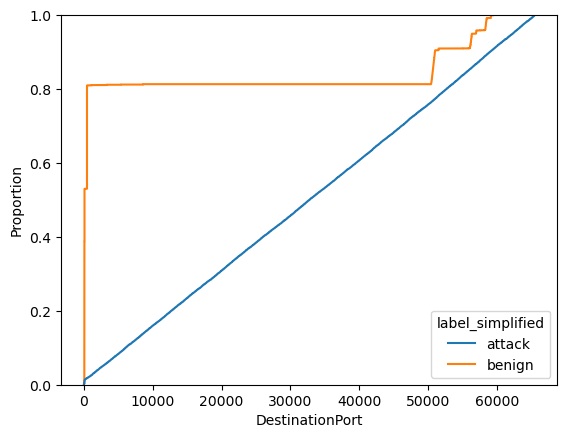

In [19]:
sns.ecdfplot(
    data = df,
    x = 'DestinationPort', # the column that you want to compute ecdf, they will be in the order from short to long length (numerical order)
    hue = 'label_simplified')

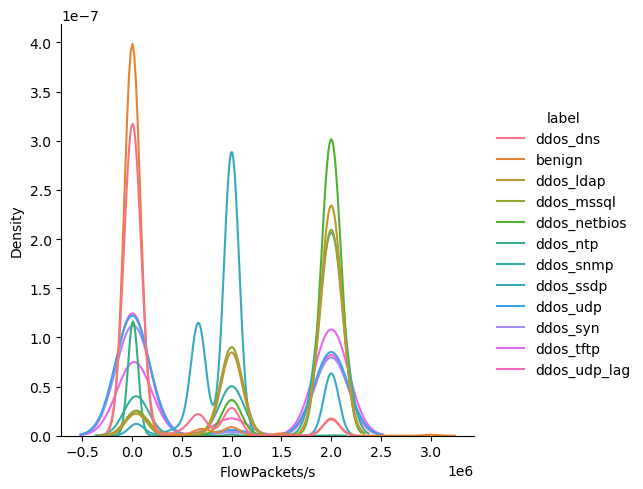

In [20]:
sns.displot(
    data = df, 
    x = "FlowPackets/s", # the column you want to check
    hue = "label", # check the distribution of different flower types
    kind = "kde" # a kernel density estimate (KDE) of the distribution, you can remove this to see the change
)

/tmp/ipykernel_8300/1905931592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])


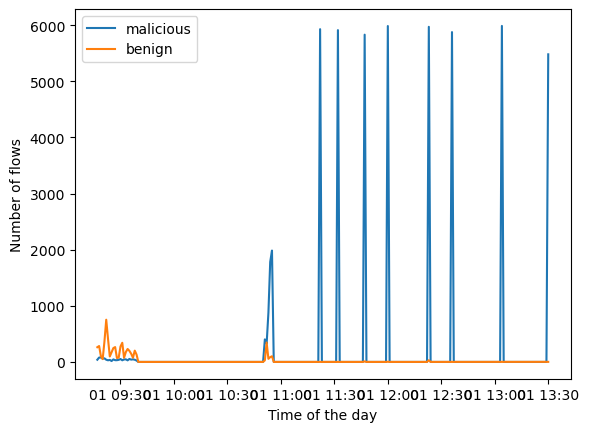

In [21]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])

df_time_b=df_masked.set_index('Timestamp')
df_time_b=df_time_b.resample('1min').size()

df_time=df.set_index('Timestamp')
df_time=df_time.resample('1min').size()
df_time_m=df_time-df_time_b

plt.figure()
sns.lineplot(data = df_time_m, label='malicious')
sns.lineplot(data = df_time_b,label='benign')
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

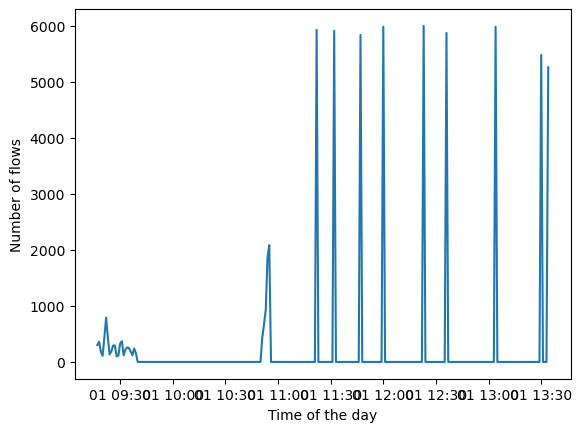

In [22]:
plt.figure()
sns.lineplot(data = df_time)
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

## 2. Generate additional features

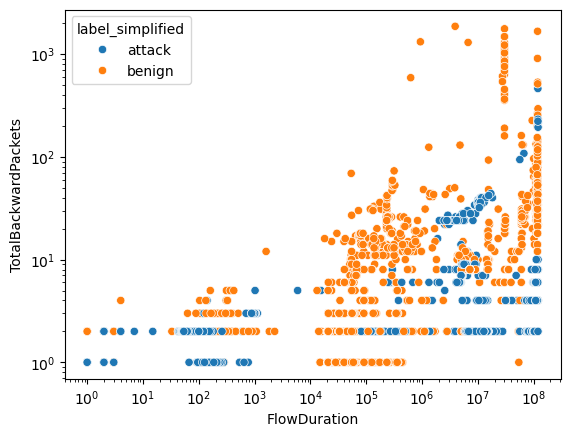

In [23]:
df['TotalBytes'] = df['TotalLengthofFwdPackets'] + df['TotalLengthofBwdPackets']
df['TotalPackets'] = df['TotalFwdPackets'] + df['TotalBackwardPackets']
df['AveragePacketLength'] = df['TotalBytes'] / df['TotalPackets']

df['Fwd/BwdPacketRatio'] = df['TotalFwdPackets'] / (df['TotalBackwardPackets'] + 1)

df['TrafficScore'] = df['TotalBytes'] * df['FlowPackets/s']

sns.scatterplot(
    data=df,
    x='FlowDuration',
    y='TotalBackwardPackets', # ????????
    hue='label_simplified') 
plt.xscale('log')
plt.yscale('log')
plt.show()

## Categorial features encoding

### Time

In [24]:
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp'] - reference_date).dt.total_seconds()

In [25]:
df

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,IdleMin,Inbound,label,ProtocolName,label_simplified,TotalBytes,TotalPackets,AveragePacketLength,Fwd/BwdPacketRatio,TrafficScore
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,5668.629638,28415,97,0,...,0.0,1,ddos_dns,UDP,attack,42680.0,97,440.0,97.0,1.456963e+08
1,192.168.50.1-172.16.0.5-634-60495-17,192.168.50.1,634,172.16.0.5,60495,17,5668.637032,2,2,0,...,0.0,0,ddos_dns,UDP,attack,880.0,2,440.0,2.0,8.800000e+08
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,5668.668689,48549,200,0,...,0.0,1,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,3.625203e+08
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,5668.706403,48337,200,0,...,0.0,1,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,3.641103e+08
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,5668.757341,32026,200,0,...,0.0,1,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,5.495535e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,13655.444439,1,2,0,...,0.0,1,ddos_udp_lag,UDP,attack,750.0,2,375.0,2.0,1.500000e+09
64235,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,13655.445153,212238,6,0,...,0.0,1,ddos_udp_lag,UDP,attack,2088.0,6,348.0,6.0,5.902807e+04
64236,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,13655.445204,1,2,0,...,0.0,1,ddos_udp_lag,UDP,attack,750.0,2,375.0,2.0,1.500000e+09
64237,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,13655.445206,108952,4,0,...,0.0,1,ddos_udp_lag,UDP,attack,1438.0,4,359.5,4.0,5.279389e+04


### Source IP and Destination IP

fixato

In [26]:
# import ipaddress


#Applicare la funzione alla colonna 'Src IP'
df['SourceIpInt'] = df['SourceIP'].apply(lambda ip : int(ipaddress.ip_address(ip)))
df['DestinationIPInt'] = df['DestinationIP'].apply(lambda ip : int(ipaddress.ip_address(ip)))

print(df[['SourceIP', 'SourceIpInt']].head())
print(df[['DestinationIP', 'DestinationIPInt']].head())

df.info()
df

       SourceIP  SourceIpInt
0    172.16.0.5   2886729733
1  192.168.50.1   3232248321
2    172.16.0.5   2886729733
3    172.16.0.5   2886729733
4    172.16.0.5   2886729733
  DestinationIP  DestinationIPInt
0  192.168.50.1        3232248321
1    172.16.0.5        2886729733
2  192.168.50.1        3232248321
3  192.168.50.1        3232248321
4  192.168.50.1        3232248321
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FlowID                   64239 non-null  object 
 1   SourceIP                 64239 non-null  object 
 2   SourcePort               64239 non-null  int64  
 3   DestinationIP            64239 non-null  object 
 4   DestinationPort          64239 non-null  int64  
 5   Protocol                 64239 non-null  int64  
 6   Timestamp                64239 non-null  float64
 7   FlowDuration          

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,label,ProtocolName,label_simplified,TotalBytes,TotalPackets,AveragePacketLength,Fwd/BwdPacketRatio,TrafficScore,SourceIpInt,DestinationIPInt
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,5668.629638,28415,97,0,...,ddos_dns,UDP,attack,42680.0,97,440.0,97.0,1.456963e+08,2886729733,3232248321
1,192.168.50.1-172.16.0.5-634-60495-17,192.168.50.1,634,172.16.0.5,60495,17,5668.637032,2,2,0,...,ddos_dns,UDP,attack,880.0,2,440.0,2.0,8.800000e+08,3232248321,2886729733
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,5668.668689,48549,200,0,...,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,3.625203e+08,2886729733,3232248321
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,5668.706403,48337,200,0,...,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,3.641103e+08,2886729733,3232248321
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,5668.757341,32026,200,0,...,ddos_dns,UDP,attack,88000.0,200,440.0,200.0,5.495535e+08,2886729733,3232248321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,13655.444439,1,2,0,...,ddos_udp_lag,UDP,attack,750.0,2,375.0,2.0,1.500000e+09,2886729733,3232248321
64235,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,13655.445153,212238,6,0,...,ddos_udp_lag,UDP,attack,2088.0,6,348.0,6.0,5.902807e+04,2886729733,3232248321
64236,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,13655.445204,1,2,0,...,ddos_udp_lag,UDP,attack,750.0,2,375.0,2.0,1.500000e+09,2886729733,3232248321
64237,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,13655.445206,108952,4,0,...,ddos_udp_lag,UDP,attack,1438.0,4,359.5,4.0,5.279389e+04,2886729733,3232248321


In [27]:
categorical_features=['label','SourceIP','DestinationIP']

label_encoder = LabelEncoder()
for feature in categorical_features:
    if feature == 'label':
        df['IntLabel'] = label_encoder.fit_transform(df[feature])
    else:  
        df[feature] = label_encoder.fit_transform(df[feature])

df

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,ProtocolName,label_simplified,TotalBytes,TotalPackets,AveragePacketLength,Fwd/BwdPacketRatio,TrafficScore,SourceIpInt,DestinationIPInt,IntLabel
0,172.16.0.5-192.168.50.1-634-60495-17,16,634,90,60495,17,5668.629638,28415,97,0,...,UDP,attack,42680.0,97,440.0,97.0,1.456963e+08,2886729733,3232248321,1
1,192.168.50.1-172.16.0.5-634-60495-17,75,634,23,60495,17,5668.637032,2,2,0,...,UDP,attack,880.0,2,440.0,2.0,8.800000e+08,3232248321,2886729733,1
2,172.16.0.5-192.168.50.1-634-46391-17,16,634,90,46391,17,5668.668689,48549,200,0,...,UDP,attack,88000.0,200,440.0,200.0,3.625203e+08,2886729733,3232248321,1
3,172.16.0.5-192.168.50.1-634-11894-17,16,634,90,11894,17,5668.706403,48337,200,0,...,UDP,attack,88000.0,200,440.0,200.0,3.641103e+08,2886729733,3232248321,1
4,172.16.0.5-192.168.50.1-634-27878-17,16,634,90,27878,17,5668.757341,32026,200,0,...,UDP,attack,88000.0,200,440.0,200.0,5.495535e+08,2886729733,3232248321,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,172.16.0.5-192.168.50.1-38625-63051-17,16,38625,90,63051,17,13655.444439,1,2,0,...,UDP,attack,750.0,2,375.0,2.0,1.500000e+09,2886729733,3232248321,11
64235,172.16.0.5-192.168.50.1-58632-18963-17,16,58632,90,18963,17,13655.445153,212238,6,0,...,UDP,attack,2088.0,6,348.0,6.0,5.902807e+04,2886729733,3232248321,11
64236,172.16.0.5-192.168.50.1-46104-64704-17,16,46104,90,64704,17,13655.445204,1,2,0,...,UDP,attack,750.0,2,375.0,2.0,1.500000e+09,2886729733,3232248321,11
64237,172.16.0.5-192.168.50.1-60686-10440-17,16,60686,90,10440,17,13655.445206,108952,4,0,...,UDP,attack,1438.0,4,359.5,4.0,5.279389e+04,2886729733,3232248321,11


## 3. Data Pre-processing

### Correlation matrix

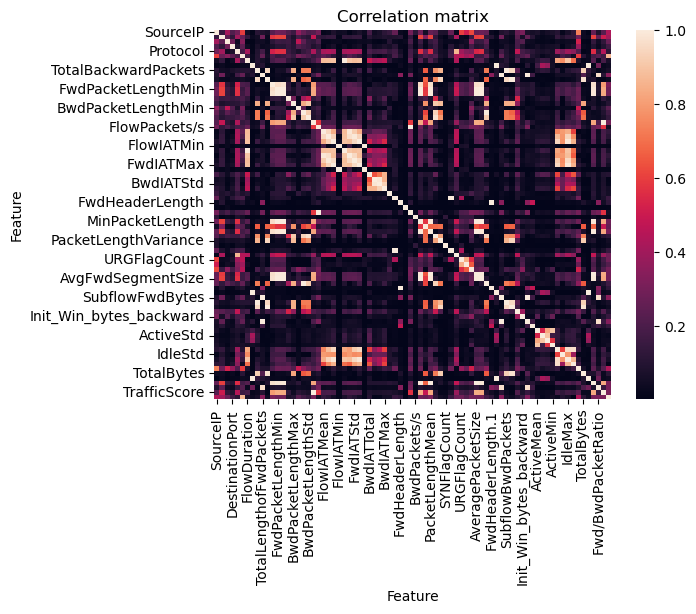

In [28]:
from sklearn.decomposition import PCA

# Compute the correlation matrix
df_corr=df.drop(columns=['label','label_simplified','FlowID','ProtocolName','SourceIpInt','DestinationIPInt'])
correlation_matrix = df_corr.corr().abs()

# Compute the heatmap
plt.figure()#figsize=(5,4))
sns.heatmap(correlation_matrix)#, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

### PCA

In [29]:
pca = PCA(random_state=42)
pca.fit(df_corr)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,42


# cella sotto ancora da modificare ....

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_8300/3761990237.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'3 PCs explain {round(perc_cumul_exp_var[2], 2)}% of $\sigma^2$')


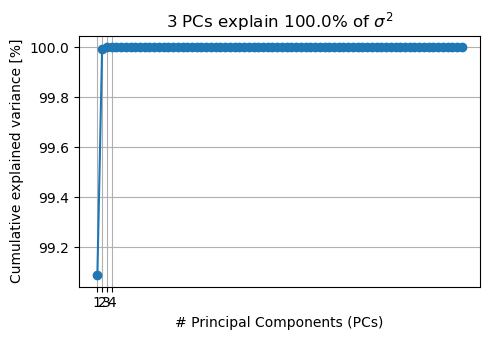

In [30]:
# describe how much of the dataset variability is indicated by a given amount of features
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(4)], [i for i in range(1,5)])
plt.grid()
plt.title(f'3 PCs explain {round(perc_cumul_exp_var[2], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()